In [1]:
import pickle

import sys
sys.path.append('..')

import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from data_loader.load_data import ImagesLoader

from sklearn.preprocessing import MinMaxScaler

from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import RandomForestClassifier, \
                             AdaBoostClassifier, \
                             ExtraTreesClassifier, \
                             StackingClassifier, \
                             VotingClassifier, \
                             BaggingClassifier

from sklearn.dummy import DummyClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, \
                            f1_score, \
                            classification_report, \
                            confusion_matrix, \
                            ConfusionMatrixDisplay

import scikitplot as skplt

from skopt import gp_minimize
from skopt.plots import plot_convergence

import shap

In [2]:
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 1000)

In [ ]:
# melhores resultados preliminares

# xgb; hsv+hu; f1=0.65
# lgbm; hsv+lbp; f1=0.66
# lsvc; hsv+lbp+hu; f1=0.65
# lgbm; hsv+lbp+hu+hog; f1=0.68
# xgb; hsv+lbp+hu+hog; f1=0.64
# lsvc; rgb+hsv+lbp+hu; f1=0.64
# xgb; rgb+hsv+lbp+hu+hog; f1=0.65
# lgbm; hsv; f1=0.66
# xgb; hsv; f1=0.64

In [3]:
DATASET_NAME = 'simpsons-small-balanced'
# DATASET_NAME = 'simpsons-medium'

FIELDS = [
    'combination_hsv+hu',
    'combination_hsv+lbp',
    'combination_hsv+lbp+hu',
    'combination_hsv+lbp+hu+hog',
    'combination_hsv+lbp+hu+hog',
    'combination_rgb+hsv+lbp+hu',
    'combination_rgb+hsv+lbp+hu+hog',
    'descriptor_hsv',
]

# **CARREGANDO OS DADOS**

In [4]:
loader = ImagesLoader(train_images_path=f'../data/{DATASET_NAME}/train/',
                      test_images_path=f'../data/{DATASET_NAME}/test/')

# data = loader.load_data()

with open(f'../data/{DATASET_NAME}/{DATASET_NAME}.pkl', 'rb') as infile:
    data = pickle.load(infile)

In [5]:
print('names_characters')
print(np.array(data['names_characters']['train']).shape,
      np.array(data['names_characters']['test']).shape, end='\n\n')

for field in FIELDS:
      print(f'{field} shape =',
            np.array(data[field]['train']).shape,
            np.array(data[field]['test']).shape)

names_characters
(324,) (95,)

combination_hsv+hu shape = (324, 775) (95, 775)
combination_hsv+lbp shape = (324, 778) (95, 778)
combination_hsv+lbp+hu shape = (324, 785) (95, 785)
combination_hsv+lbp+hu+hog shape = (324, 65081) (95, 65081)
combination_hsv+lbp+hu+hog shape = (324, 65081) (95, 65081)
combination_rgb+hsv+lbp+hu shape = (324, 1553) (95, 1553)
combination_rgb+hsv+lbp+hu+hog shape = (324, 65849) (95, 65849)
descriptor_hsv shape = (324, 768) (95, 768)


In [6]:
print('bart =', data['names_characters']['train'].tolist().count('bart'))
print('homer =', data['names_characters']['train'].tolist().count('homer'))
print('lisa =', data['names_characters']['train'].tolist().count('lisa'))
print('marge =', data['names_characters']['train'].tolist().count('marge'))
print('maggie =', data['names_characters']['train'].tolist().count('maggie'))

bart = 81
homer = 80
lisa = 75
marge = 59
maggie = 29


# **TRAIN-TEST SPLIT**

In [5]:
y_train = np.array(data['names_encoded']['train'])
y_test = np.array(data['names_encoded']['test'])

y_train.shape, y_test.shape

((324,), (95,))

# **SETUP**

In [6]:
def plot_summary(field, clf):
    print(field)

    X_train = data[field]['train']
    X_test = data[field]['test']

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    # print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    cm_plot = ConfusionMatrixDisplay(cm, display_labels=loader.labels)
    cm_plot.plot(cmap='viridis_r');

    plt.title(f"{field};\n accuracy = " \
            f"{round(accuracy_score(y_test, y_pred), 2)}; " \
            f"weight f1 = " \
            f"{round(f1_score(y_test, y_pred, average='weighted'), 2)}");

    plt.show();

In [10]:
estimators = [
    ('lsvc', LinearSVC(random_state=42)),
    ('mlp', MLPClassifier(random_state=42)),
    ('lr', LogisticRegression(random_state=42)),
    ('xgb', XGBClassifier(random_state=42)),
    ('lgbm', LGBMClassifier(random_state=42))
]

# **TREINO E TESTE DOS MODELOS**

In [ ]:
estimators_fields = [
    ('xgb', 'combination_hsv+hu', XGBClassifier(random_state=42)),
    ('lgbm', 'combination_hsv+lbp', LGBMClassifier(random_state=42)),
    ('lsvc', 'combination_hsv+lbp+hu', LinearSVC(random_state=42)),
    ('lgbm', 'combination_hsv+lbp+hu+hog', LGBMClassifier(random_state=42)),
    ('xgb', 'combination_hsv+lbp+hu+hog', XGBClassifier(random_state=42)),
    ('lsvc', 'combination_rgb+hsv+lbp+hu', LinearSVC(random_state=42)),
    ('xgb', 'combination_rgb+hsv+lbp+hu+hog', XGBClassifier(random_state=42)),
    ('lgbm', 'descriptor_hsv', LGBMClassifier(random_state=42)),
    ('xgb', 'descriptor_hsv', XGBClassifier(random_state=42))
]

# predições
preds = {estimator[0] + '_' + estimator[1]: [] for estimator in estimators_fields}

for estimator in estimators_fields:
    estimator_name = estimator[0]
    field = estimator[1]
    model = estimator[2]

    X_train = np.array(data[field]['train'])
    X_test = np.array(data[field]['test'])

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    preds[estimator_name + '_' + field] = y_pred

    print(f'{estimator_name}_{field}', 'completed')

In [ ]:
for model, pred in zip(list(preds.keys()), list(preds.values())):
    f1 = f1_score(y_test, pred, average='weighted')
    print(model, '=', f1)

# **OTIMIZAÇÕES**

In [113]:
# xgb; hsv+hu; f1=0.65
# lgbm; hsv+lbp; f1=0.66
# lsvc; hsv+lbp+hu; f1=0.65
# lsvc; rgb+hsv+lbp+hu; f1=0.64
# lgbm; hsv; f1=0.66
# xgb; hsv; f1=0.64

[0.1, 2, 1, 0.7924528621169169, 0.6520396059262403]
0.7274180734856007


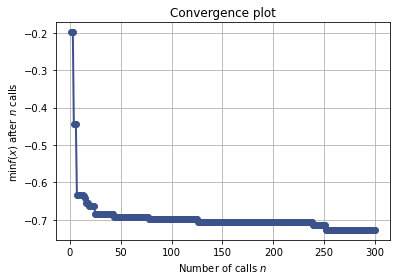

In [7]:
# xgb; hsv+hu; f1=0.65

X_train = data['combination_hsv+hu']['train']
X_test = data['combination_hsv+hu']['test']

def train_model(params):
    clf = XGBClassifier(
        eta=params[0],
        max_depth=params[1],
        min_child_weight=params[2],
        subsample=params[3],
        colsample_bytree=params[4],
        random_state=42,
        n_estimators=100
    )

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')

    return -f1

space = [
    [1e-3, 1e-1],  # learning rate
    [2, 128],      # max_depth
    [1, 100],      # min_child_weight
    [.05, 1.0],    # subsample
    [.1, 1.0]      # colsample_bytree
]

# gaussian process optimization
result = gp_minimize(
    train_model,
    space,
    random_state=42,
    verbose=0,
    n_calls=300,
    n_random_starts=10
)

print(result.x)
print(abs(result.fun))

plot_convergence(result);

[0.05899095873140777, 20, 47, 0.6239620710856534, 0.631625594571926]
0.6806905139956135


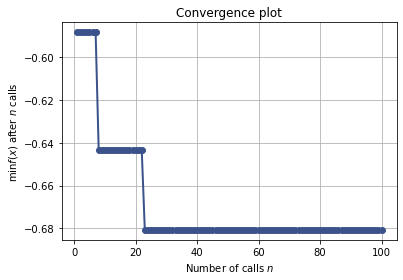

In [9]:
# lgbm; hsv+lbp; f1=0.66

X_train = data['combination_hsv+lbp']['train']
X_test = data['combination_hsv+lbp']['test']

def train_model(params):
    clf = LGBMClassifier(
        learning_rate=params[0],
        num_leaves=params[1],
        min_child_samples=params[2],
        subsample=params[3],
        colsample_bytree=params[4],
        random_state=42,
        subsample_freq=1,
        n_estimators=100
    )

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')

    return -f1

space = [
    [1e-3, 1e-1],  # learning rate
    [2, 128],      # num_leaves
    [1, 100],      # min_child_samples
    [.05, 1.0],    # subsample
    [.1, 1.0]      # colsample_bytree
]

# gaussian process optimization
result = gp_minimize(
    train_model,
    space,
    random_state=42,
    verbose=0,
    n_calls=100,
    n_random_starts=10
)

print(result.x)
print(abs(result.fun))

plot_convergence(result);

# **VOTING DE CLASSIFICADORES JÁ TREINADOS**

In [19]:
y_pred = voting(args=list(preds.values()),
                weights=[1,1,1,1,1,1,1,1,1])

y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 4, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 4, 4, 4, 4, 1, 4, 0, 4, 4, 4, 0, 0, 2, 0, 3,
       3, 3, 1, 0, 0, 3, 0], dtype=int64)

In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      1.00      0.79        35
           1       0.81      0.84      0.82        25
           2       0.50      0.08      0.13        13
           3       1.00      0.40      0.57        10
           4       0.89      0.67      0.76        12

    accuracy                           0.73        95
   macro avg       0.77      0.60      0.62        95
weighted avg       0.74      0.73      0.68        95



# **VOTING DE STACKS JÁ TREINADAS**

In [11]:
# dados de treino para cada stack
fields = [
    'combination_hsv+hu',
    'combination_hsv+lbp+hu',
    'descriptor_hsv'
]

final_estimators = [
    XGBClassifier(random_state=42),
    LinearSVC(random_state=42),
    LGBMClassifier(random_state=42)
]

preds = {}

for i in range(len(fields)):
    stack = StackingClassifier(estimators=estimators,
                               final_estimator=final_estimators[i],
                               stack_method='auto',
                               verbose=0)

    X_train = np.array(data[fields[i]]['train'])
    X_test = np.array(data[fields[i]]['test'])

    stack.fit(X_train, y_train)
    y_pred = stack.predict(X_test)

    preds[fields[i]] = y_pred
    print(f'stack {fields[i]} completed')

stack combination_hsv+hu completed
stack combination_hsv+lbp+hu completed
stack descriptor_hsv completed


              precision    recall  f1-score   support

           0       0.73      0.94      0.83        35
           1       0.78      0.84      0.81        25
           2       0.86      0.46      0.60        13
           3       0.75      0.60      0.67        10
           4       1.00      0.67      0.80        12

    accuracy                           0.78        95
   macro avg       0.82      0.70      0.74        95
weighted avg       0.80      0.78      0.77        95



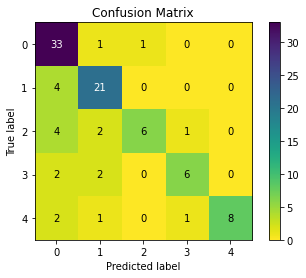

In [14]:
y_pred = voting(args=list(preds.values()),
                weights=[3,1,2])

print(classification_report(y_test, y_pred))

skplt.metrics.plot_confusion_matrix(
    y_test, y_pred, cmap='viridis_r',
);

              precision    recall  f1-score   support

           0       0.78      0.91      0.84        35
           1       0.81      0.84      0.82        25
           2       0.86      0.46      0.60        13
           3       0.82      0.90      0.86        10
           4       0.90      0.75      0.82        12

    accuracy                           0.81        95
   macro avg       0.83      0.77      0.79        95
weighted avg       0.82      0.81      0.80        95



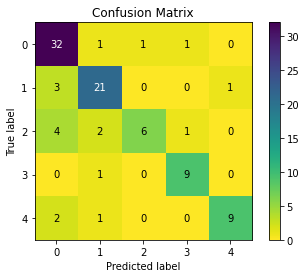

In [19]:
y_pred = voting(args=list(preds.values()),
                weights=[[1,1,1],
                         [1,1,1],
                         [1,1,1],
                         [3,3,3],
                         [4,4,4],])

print(classification_report(y_test, y_pred))

skplt.metrics.plot_confusion_matrix(
    y_test, y_pred, cmap='viridis_r',
);

In [16]:
random_weights = []
weighted_f1 = []

for i in range(10000):

    weights = [[random.randint(1,3) for i in range(3)] for i in range(5)]

    y_pred = voting(args=list(preds.values()),
                    weights=weights)

    weighted_f1.append(
        f1_score(y_test, y_pred, average='weighted')
    )

    random_weights.append(weights)

idx = np.argmax(weighted_f1)

print(weighted_f1[idx])
print(np.array(random_weights[idx]))

0.8016817857065534
[[1, 1, 1], [1, 1, 3], [2, 3, 2], [1, 1, 3], [2, 2, 1]]


              precision    recall  f1-score   support

           0       0.77      0.94      0.85        35
           1       0.77      0.92      0.84        25
           2       0.86      0.46      0.60        13
           3       1.00      0.70      0.82        10
           4       1.00      0.67      0.80        12

    accuracy                           0.81        95
   macro avg       0.88      0.74      0.78        95
weighted avg       0.83      0.81      0.80        95



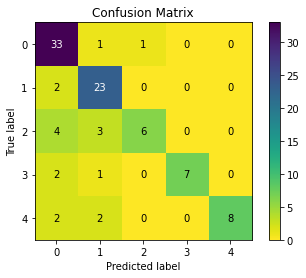

In [18]:
y_pred = voting(args=list(preds.values()),
                weights=random_weights[idx])

print(classification_report(y_test, y_pred))

skplt.metrics.plot_confusion_matrix(
    y_test, y_pred, cmap='viridis_r',
);

# **EXPLICABILIDADE (SHAP)**

              precision    recall  f1-score   support

           0       0.61      0.97      0.75        35
           1       0.72      0.84      0.78        25
           2       1.00      0.08      0.14        13
           3       1.00      0.40      0.57        10
           4       1.00      0.42      0.59        12

    accuracy                           0.68        95
   macro avg       0.87      0.54      0.57        95
weighted avg       0.78      0.68      0.63        95



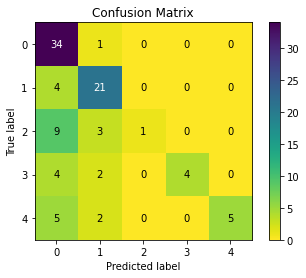

In [28]:
clf = LGBMClassifier()

X_train = np.array(data['combination_hsv+lbp+hu']['train'])
X_test = np.array(data['combination_hsv+lbp+hu']['test'])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

skplt.metrics.plot_confusion_matrix(
    y_test, y_pred, cmap='viridis_r',
);

In [31]:
explainer = shap.TreeExplainer(model=clf)
shap_values = explainer.shap_values(X_train)

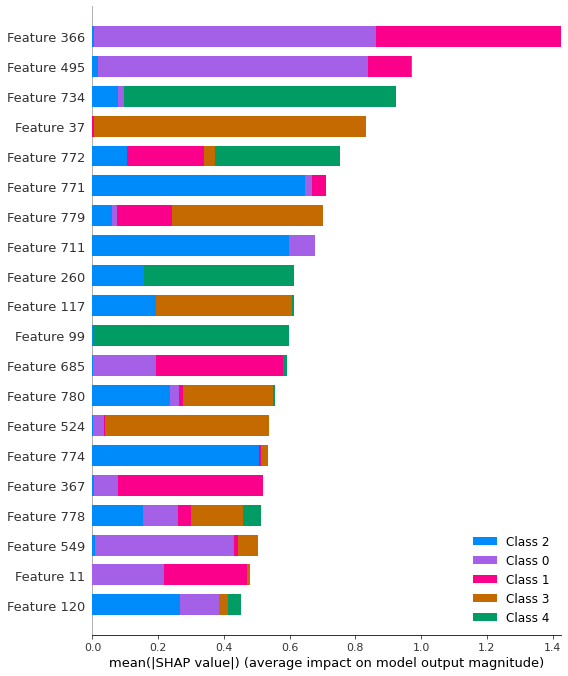

In [36]:
shap.summary_plot(shap_values=shap_values, features=X_train);